# 3.2 线性回归的从零开始实现

在了解了线性回归的背景知识之后，现在我们可以动手实现它了。尽管强大的深度学习框架可以减少大量重复性工作，但若过于依赖它提供的便利，会导致我们很难深入理解深度学习是如何工作的。因此，本节将介绍如何只利用`Tensor`和`autograd`来实现一个线性回归的训练。

首先，导入本节中实验所需的包或模块，其中的matplotlib包可用于作图，且设置成嵌入显示。

In [2]:
%matplotlib inline
import tensorflow as tf
print(tf.__version__)
from matplotlib import pyplot as plt
import random

/root/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/root/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/root/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/root/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


2.1.0


## 3.2.1 生成数据集

我们构造一个简单的人工训练数据集，它可以使我们能够直观比较学到的参数和真实的模型参数的区别。设训练数据集样本数为1000，输入个数（特征数）为2。给定随机生成的批量样本特征 $\boldsymbol{X} \in \mathbb{R}^{1000 \times 2}$，我们使用线性回归模型真实权重 $\boldsymbol{w} = [2, -3.4]^\top$ 和偏差 $b = 4.2$，以及一个随机噪声项 $\epsilon$ 来生成标签
$$
\boldsymbol{y} = \boldsymbol{X}\boldsymbol{w} + b + \epsilon
$$
其中噪声项 $\epsilon$ 服从均值为0、标准差为0.01的正态分布。噪声代表了数据集中无意义的干扰。下面，让我们生成数据集。

In [3]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = tf.random.normal((num_examples, num_inputs), stddev=1)
labels = true_w[0] * features[:,0] + true_w[1] * features[:, 1] + true_b
labels += tf.random.normal(labels.shape, stddev=0.01)

注意，`features`的每一行是一个长度为2的向量，而`labels`的每一行是一个长度为1的向量（标量）。

In [4]:
print(features[0], labels[0])

tf.Tensor([-0.622976    0.31687057], shape=(2,), dtype=float32) tf.Tensor(1.871589, shape=(), dtype=float32)


通过生成第二个特征`features[:, 1]`和标签 `labels` 的散点图，可以更直观地观察两者间的线性关系。

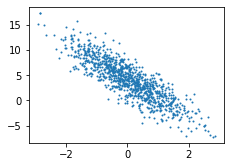

In [7]:
def set_figsize(figsize=(3.5, 2.5)):
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features[:, 1], labels, 1)

## 3.2.2 读取数据

在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。这里我们定义一个函数：它每次返回`batch_size`（批量大小）个随机样本的特征和标签。

In [35]:
import numpy as np
def data_iter(batch_size, features, labels):
    # features = np.array(features)
    # labels = np.array(labels)
    num_examples = len(features)
    indices = list(range(num_examples))
    # 样本读取顺序随机，会遍历所有样本
    random.shuffle(indices)
    # 每次取 batch_size 的数据
    for i in range(0, num_examples, batch_size):
        j = indices[i: min(i+batch_size, num_examples)]
        # axis表示维度，indices表示在axis维度上要取数据的索引
        # tf.gather（在某一维度指定index）
        # yield features[j], labels[j]
        yield tf.gather(features, axis=0, indices=j), tf.gather(labels, axis=0, indices=j)

让我们读取第一个小批量数据样本并打印。每个批量的特征形状为(10, 2)，分别对应批量大小和输入个数；标签形状为批量大小。

In [36]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tf.Tensor(
[[ 0.04718596 -1.5959413 ]
 [ 0.3889716  -1.5288432 ]
 [-1.8489572   1.66422   ]
 [-1.3978077  -0.85818154]
 [-0.36940867 -0.619267  ]
 [-0.15660426  1.1231796 ]
 [ 0.89411694  1.5499148 ]
 [ 1.9971682  -0.56981105]
 [-2.1852891   0.18805206]
 [ 1.3222371  -1.0301086 ]], shape=(10, 2), dtype=float32) tf.Tensor(
[ 9.738684   10.164594   -5.15065     4.3305573   5.568048    0.06494669
  0.7251317  10.128626   -0.8036391  10.343082  ], shape=(10,), dtype=float32)


## 3.2.3 初始化模型参数

我们将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0。

In [37]:
w = tf.Variable(tf.random.normal((num_inputs, 1), stddev=0.01))
b = tf.Variable(tf.zeros((1,)))

## 3.2.4 定义模型

下面是线性回归的矢量计算表达式的实现。我们使用`matmul`函数做矩阵乘法。

In [38]:
def linreg(X, w, b):
    return tf.matmul(X, w) + b

## 3.2.5 定义损失函数

我们使用上一节描述的平方损失来定义线性回归的损失函数。在实现中，我们需要把真实值`y`变形成预测值`y_hat`的形状(因为 `y_hat` 计算后 `shape= (10,1)`, 而真实值 `y` 的 `shape = (10,)`,即单行向量)。以下函数返回的结果也将和`y_hat`的形状相同。

In [44]:
def squared_loss(y_hat, y):
    return (y_hat - tf.reshape(y, y_hat.shape)) ** 2 / 2
    #return (y_hat - y) ** 2 / 2

## 3.2.6 定义优化算法

以下的`sgd`函数实现了上一节中介绍的小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数。这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量大小来得到平均值。

In [33]:
def sgd(params, lr, batch_size, grads):
    """
    Mini-batch stochastic gradient descent.
    lr: 步长
    """
    # 对每一个参数求梯度，并更新
    for i, param in enumerate(params):
        param.assign_sub(lr * grads[i] / batch_size)

## 3.2.7 训练模型

在训练中，我们将多次迭代模型参数。在每次迭代中，我们根据当前读取的小批量数据样本（特征`X`和标签`y`），通过调用反向函数`t.gradients`计算小批量随机梯度，并调用优化算法`sgd`迭代模型参数。由于我们之前设批量大小`batch_size`为 10，每个小批量的损失`l`的形状为 (10, 1)。回忆一下自动求梯度一节。由于变量`l`并不是一个标量，所以我们可以调用`reduce_sum()`将其求和得到一个标量，再运行`t.gradients`得到该变量有关模型参数的梯度。注意在每次更新完参数后不要忘了将参数的梯度清零。

在一个迭代周期（epoch）中，我们将完整遍历一遍`data_iter`函数，并对训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。这里的迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设 3 和 0.03。在实践中，大多超参数都需要通过反复试错来不断调节。虽然迭代周期数设得越大模型可能越有效，但是训练时间可能过长。而有关学习率对模型的影响，我们会在后面 “优化算法” 一章中详细介绍。

In [49]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with tf.GradientTape() as t:
            t.watch([w, b])
            #print(net(X, w, b))
            #print(y)
            l = loss(net(X, w, b), y)
            l = tf.reduce_sum(l)
        # 求 w ，b 梯度
        grads = t.gradient(l, [w,b])
        # 梯度下降, 更新参数
        sgd([w, b], lr, batch_size, grads)       
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, tf.reduce_mean(train_l)))

epoch 1, loss 0.000051
epoch 2, loss 0.000051
epoch 3, loss 0.000051


In [51]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 2.00006  ],
       [-3.3998876]], dtype=float32)>
4.2 
 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([4.200227], dtype=float32)>


## 小结

- 可以看出，仅使用`Variables`和`GradientTape`模块就可以很容易地实现一个模型。